# Responding to Events


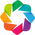

In [2]:
import numpy as np
import holoviews as hv
import numpy as np
hv.extension('bokeh')

In the [Live Data](./06-Live_Data.ipynb) guide we saw how ``DynamicMap`` allows us to explore high dimensional data using the widgets in the same style as ``HoloMaps``. Although suitable for unbounded exploration of large parameter spaces, the ``DynamicMaps`` described in that notebook support exactly the same mode of interaction as ``HoloMaps``. In particular, the key dimensions are used to specify a set of widgets that when manipulated apply the appopriate indexing to invoke the user-supplied callable.

In this user guide we will explore the HoloViews streams system that allows *any* sort of value to be supplied from *anywhere*. This system opens a huge set of new possible visualization types, including continuously updating plots that reflect live data as well as dynamic visualizations that can be interacted with directly, as described in the [Custom Interactivity](./12-Custom_Interactivity.ipynb) guide.

<center><div class="alert alert-info" role="alert">To use visualize and use a <b>DynamicMap</b> you need to be running a live Jupyter server.<br>This user guide assumes that it will be run in a live notebook environment.<br>
When viewed statically, DynamicMaps will only show the first available Element.<br></div></center>

In [3]:
# Styles and plot options used in this user guide
%opts Ellipse [bgcolor='white'] (color='black')
%opts Image (cmap='viridis')
%opts VLine HLine (color='red' line_width=2)
%opts Path [show_grid=False bgcolor='white'] (color='black' line_dash='dashdot')
%opts Area (fill_color='cornsilk' line_width=2 line_color='black')

## A simple ``DynamicMap``

Before introducing streams, let us declare a simple ``DynamicMap`` of the sort discussed in the [Live Data](06-Live_Data.ipynb) user guide. This example consists of a ``Curve`` element showing a [Lissajous curve](https://en.wikipedia.org/wiki/Lissajous_curve) with ``VLine`` and ``HLine`` annotations to form a crosshair:

In [4]:
lin = np.linspace(-np.pi,np.pi,300)

def lissajous(t, a,b, delta):
    return (np.sin(a * t + delta), np.sin(b * t))

def lissajous_curve(t, a=3,b=5, delta=np.pi/2):
    (x,y) = lissajous(t,a,b,delta)
    return hv.Path(lissajous(lin,a,b,delta)) * hv.VLine(x) * hv.HLine(y)

hv.DynamicMap(lissajous_curve, kdims='t').redim.range(t=(-3.,3.))

:DynamicMap   [t]

As expected, the declared key dimension (``kdims``) has turned into a slider widget that lets us move the crosshair along the curve. Now let's see how to position the crosshair using streams.

## Introducing streams



The core concept behind a stream is simple: it is a parameter that can change over time that automatically refreshes code depending on those parameter values. 

Like all objects in HoloViews, these parameters are declared using [param](https://ioam.github.io/param) and streams are defined as a parameterized subclass of the ``holoviews.streams.Stream``. A more convenient way is to use the ``Stream.define`` classmethod:

In [ ]:
from holoviews.streams import Stream, param
Time = Stream.define('Time', t=0.0)

This results in a ``Time`` class with a numeric ``t`` parameter that defaults to zero. As this object is parameterized, we can use ``hv.help`` to view it's parameters:

In [ ]:
hv.help(Time)

This parameter is a ``param.Number`` as we supplied a float, if we had supplied an integer it would have been a ``param.Integer``. Notice that there is no docstring in the help output above but we can add one by explicitly defining the parameter as follows:

In [ ]:
Time = Stream.define('Time', t=param.Number(default=0.0, doc='A time parameter'))
hv.help(Time)

Now we have defined this ``Time`` stream class, we can make of an instance of it and look at its parameters:

In [ ]:
time_dflt = Time()
print('This Time instance has parameter t={t}'.format(t=time_dflt.t))

As with all parameterized classes, we can choose to instantiate our parameters with suitable values instead of relying on defaults.

In [ ]:
time = Time(t=np.pi/4)
print('This Time instance has parameter t={t}'.format(t=time.t))

For more information on defining ``Stream`` classes this way, use ``hv.help(Stream.define)``.

### Simple streams example

We can now supply this streams object to a ``DynamicMap`` using the same ``lissajous_curve`` callback above by adding it to the ``streams`` list:

In [ ]:
dmap = hv.DynamicMap(lissajous_curve, streams=[time])
dmap + lissajous_curve(t=np.pi/4)

Immediately we see that the crosshair position of the ``DynamicMap`` reflects the ``t`` parameter values we set on the ``Time`` stream. This means that the ``t`` parameter  was supplied as the argument  to the ``lissajous_curve`` callback. As we now have no key dimensions, there is no longer a widget for the ``t`` dimensions.

Although we have what looks like a static plot, it is in fact dynamic and can be updated in place at any time. To see this, we can call the ``event`` method on our ``DynamicMap``:


In [ ]:
dmap.event( t=0.2)

Running this cell will have updated the crosshair from its original position where $t=\frac{\pi}{4}$ to a new position where ``t=0.2``. Try running the cell above with different values of ``t`` and watch the plot update!

This ``event`` method is the recommended way of updating the stream parameters on a ``DynamicMap`` but if you have a handle on the relevant stream instance, you can also call the ``event`` method on that:

In [ ]:
time.event(t=-0.2)

Running the cell above also moves the crosshair to a new position. As there are no key dimensions, there is only a single valid (empty) key that can be accessed with ``dmap[()]`` or ``dmap.select()`` making ``event`` the only way to explore new parameters.

We will examine the ``event`` method and the machinery that powers streams in more detail later in the user guide after we have looked at more examples of how streams are used in practice.

### Working with multiple streams

The previous example showed a curve parameterized by a single dimension ``t``. Often you will have multiple stream parameters you would like to declare as follows:

In [ ]:
ls = np.linspace(0, 10, 200)
xx, yy = np.meshgrid(ls, ls)

XY = Stream.define('XY',x=0.0,y=0.0)

def marker(x,y):
    return hv.Image(np.sin(xx)*np.cos(yy)) * hv.VLine(x) * hv.HLine(y)

dmap = hv.DynamicMap(marker, streams=[XY()])
dmap

You can update both ``x`` and ``y`` by passing multiple keywords to the ``event`` method:

In [ ]:
dmap.event(x=-0.2, y=0.1)

Note that the definition above behaves the same as the following definition where we define separate ``X`` and ``Y`` stream classes:

```python
X = Stream.define('X',x=0.0)
Y = Stream.define('Y',y=0.0)
hv.DynamicMap(crosshairs, streams=[X(),Y()])
```

The reason why you might want to list multiple streams instead of always defining a single stream containing all the required stream parameters will be made clear in the [Custom Interactivity](./12-Custom_Interactivity.ipynb) guide.

## Combining streams and key dimensions


All the ``DynamicMap`` examples above can't be indexed with anything other than ``dmap[()]`` or ``dmap.select()`` as none of them had any key dimensions. This was to focus exclusively on the streams system at the start of the user guide and not because you can't combine key dimensions and streams:

In [ ]:
xs = np.linspace(-3, 3, 400)

def function(xs, time):
    "Some time varying function"
    return np.exp(np.sin(xs+np.pi/time))

def integral(limit, time):
    curve = hv.Curve((xs, function(xs, time)))[limit:]
    area  = hv.Area ((xs, function(xs, time)))[:limit]
    summed = area.dimension_values('y').sum() * 0.015  # Numeric approximation
    return (area * curve * hv.VLine(limit) * hv.Text(limit + 0.5, 2.0, '%.2f' % summed))

Time = Stream.define('Time', time=1.0)
dmap=hv.DynamicMap(integral, kdims='limit', streams=[Time()]).redim.range(limit=(-3,2))
dmap

In this example, you can drag the slider to see a numeric approximation to the integral on the left side on the ``VLine``.

As ``'limit'`` is declared as a key dimension, it is given a normal HoloViews slider. As we have also defined a ``time`` stream, we can update the displayed curve for any time value:

In [ ]:
dmap.event(time=8)

We now see how to control the ``time`` argument of the integral function by triggering an event with a new time value, and how to control the ``limit`` argument by moving a slider. Controlling ``limit`` with a slider this way is valid but also a little unintuitive: what if you could control ``limit`` just by hovering over the plot?

In the [Custom Interactivity](12-Custom_Interactivity.ipynb) user guide, we will see how we can do exactly this by switching to the bokeh backend and using the linked streams system.

### Matching names to arguments

Note that in the example above, the key dimension names and the stream parameter names match the arguments to the callable. This *must* be true for stream parameters but this isn't a requirement for key dimensions: if you replace the word 'radius' with 'size' in the example above after ``XY`` is defined, the example still works. 

Here are the rules regarding the callback argument names:

* If your key dimensions and stream parameters match the callable argument names, the definition is valid.
* If your callable accepts mandatory positional arguments and their number matches the number of key dimensions, the names don't need to match and these arguments will be passed key dimensions values.

As stream parameters always need to match the argument names, there is a method to allow them to be easily renamed. Let's say you imported a stream class as shown in  [Custom_Interactivity](12-Custom_Interactivity.ipynb) or for this example, reuse the existing ``XY`` stream class. You can then use the ``rename`` method allowing the following definition:

In [ ]:
def integral2(lim, t): 
    'Same as integral with different argument names'
    return integral(lim, t)

dmap = hv.DynamicMap(integral2, kdims='limit', streams=[Time().rename(time='t')]).redim.range(limit=(-3.,3.))
dmap

Occasionally, it is useful to suppress some of the stream parameters of a stream class, especially when using the *linked streams* described in [Custom_Interactivity](12-Custom_Interactivity.ipynb). To do this you can rename the stream parameter to ``None`` so that you no longer need to worry about it being passed as an argument to the callable. To re-enable a stream parameter, it is sufficient to either give the stream parameter it's original string name or a new string name.

## Overlapping stream and key dimensions

In the above example above, the stream parameters do not overlap with the declared key dimension. What happens if we add 'time' to the declared key dimensions?


In [ ]:
dmap=hv.DynamicMap(integral, kdims=['time','limit'], streams=[Time()]).redim.range(limit=(-3.,3.))
dmap

First you might notice that the 'time' value is now shown in the title but that there is no corresponding time slider as its value is supplied by the stream.

The 'time' parameter is now an instance of what are called 'dimensioned streams' which reenable indexing of these dimensions:

In [ ]:
dmap[1,0] + dmap.select(time=3,limit=1.5) + dmap[None,1.5]

In **A**, we supply our own values for the 'time and 'limit' parameters. This doesn't change the values of the 'time' parameters on the stream itself but it does allow us to see what would happen when the time value is one. Note the use of ``None`` in **C** as a way of leaving an explicit value unspecified, allowing the current stream value to be used.

This is one good reason to use dimensioned streams - it restores access to convenient indexing and selecting operation as a way of exploring your visualizations. The other reason it is useful is that if you keep all your parameters dimensioned, it re-enables the ``DynamicMap`` cache described in the [Live Data](06-Live_Data.ipynb), allowing you to record your interaction with streams and allowing you to cast to ``HoloMap`` for export:

In [ ]:
dmap.reset()  # Reset the cache, we don't want the values from the cell above
# TODO: redim the limit dimension to a default of 0
dmap.event(time=1)
dmap.event(time=1.5)
dmap.event(time=2)
hv.HoloMap(dmap)

One use of this would be to have a simulator drive a visualization forward using ``event`` in a loop. You could then stop your simulation and retain the recent history of the output as long as the allowed ``DynamicMap`` cache.

## Generators and argument-free callables

In addition to callables, Python supports [generators](https://docs.python.org/3/glossary.html#term-generator) that can be defined with the ``yield`` keyword. Calling a function that uses yield returns a [generator iterator](https://docs.python.org/3/glossary.html#term-generator-iterator) object that accepts no arguments but returns new values when iterated or when ``next()`` is applied to it.

HoloViews supports Python generators for completeness and [generator expressions](https://docs.python.org/3/glossary.html#term-generator-expression) can be a convenient way to define code inline instead of using lambda functions. As generators expressions don't accept arguments and can get 'exhausted' ***we recommend using callables with ``DynamicMap``*** - exposing the relevant arguments also exposes control over your visualization.

Unlike generators, callables that have arguments allow you to re-visit portions of your parameter space instead of always being forced in one direction via calls to ``next()``. With this caveat in mind, here is an example of a generator and the corresponding generator iterator that returns a ``BoxWhisker`` element:

In [ ]:
def sample_distributions(samples=10, tol=0.04):
    np.random.seed(42)
    while True:
        gauss1 = np.random.normal(size=samples)
        gauss2 = np.random.normal(size=samples)
        data = (['A']*samples + ['B']*samples, np.hstack([gauss1, gauss2]))
        yield hv.BoxWhisker(data, 'Group', 'Value')
        samples+=1
        
sample_generator = sample_distributions()

This returns two box whiskers representing samples from two Gaussian distributions of 10 samples. Iterating over this generator simply resamples from these distributions using an additional sample each time.

As with a callable, we can pass our generator iterator to ``DynamicMap``:

In [ ]:
hv.DynamicMap(sample_generator)

Without using streams, we now have a problem as there is no way to trigger the generator to view the next distribution in the sequence. We can solve this by defining a stream with no parameters:

In [ ]:
dmap = hv.DynamicMap(sample_generator, streams=[Stream.define('Next')()])
dmap

### Stream event update loops

Now we can simply use ``event()`` to drive the generator forward and update the plot, showing how the two Gaussian distributions converge as the number of samples increase.

In [ ]:
for i in range(40):
    dmap.event()

Note that there is a better way to run loops that drive ``dmap.event()`` which supports a ``period`` (in seconds) between updates and a ``timeout`` argument (also in seconds):

In [ ]:
dmap.periodic(0.1, 1000, timeout=3)

In this generator example, ``event`` does not require any arguments but you can set the ``param_fn`` argument to a callable that takes an iteration counter and returns a dictionary for setting the stream parameters. In addition you can use ``block=False`` to avoid blocking the notebook using a threaded loop. This can be very useful although it has two downsides 1. all running visualizations using non-blocking updates will be competing for computing resources 2. if you override a variable that the thread is actively using, there can be issues with maintaining consistent state in the notebook.

Generally, the ``periodic`` utility is recommended for all such event update loops and it will be used instead of explicit loops in the rest of the user guides involving streams.


### Using ``next()``

The approach shown above of using an empty stream works in an exactly analogous fashion for callables that take no arguments. In both cases, the ``DynamicMap`` ``next()`` method is enabled:

In [ ]:
hv.HoloMap({i:next(dmap) for i in range(10)}, kdims='Iteration')

## Next steps

The streams system allows you to update plots in place making it possible to build live visualizations that update in response to incoming live data or any other type of event. As we have seen in this user guide, you can use streams together with key dimensions to add additional interactivity to your plots while retaining the familiar widgets.

This user guide used examples that work with either the matplotlib or bokeh backends. In the [Custom Interactivity](12-Custom_Interactivity.ipynb) user guide, you will see how you can directly interact with dynamic visualizations when using the bokeh backend.

## [Advanced] How streams work



This optional section is not necessary for users who simply want to use the streams system, but it does describe how streams actually work in more detail.

A stream class is one that inherits from ``Stream`` that typically defines some new parameters. We have already seen one convenient way of defining a stream class:

In [ ]:
defineXY = Stream.define('defineXY', x=0.0, y=0.0)

This is equivalent to the following definition which would be more appropriate in library code or for complex stream class requiring lots of parameters that need to be documented:

In [ ]:
class XY(Stream):
    x = param.Number(default=0.0, constant=True, doc='An X position.')
    y = param.Number(default=0.0, constant=True, doc='A Y position.')

As we have already seen, we can make an instance of ``XY`` with some initial values for ``x`` and ``y``.

In [ ]:
xy = XY(x=2,y=3)

However, trying to modify these parameters directly will result in an exception as they have been declared constant (e.g ``xy.x=4`` will throw an error). This is because there are two allowed ways of modifying these parameters, the simplest one being ``update``:

In [ ]:
xy.update(x=4,y=50)
xy.rename(x='xpos', y='ypos').contents

This shows how you can update the parameters and also shows the correct way to view the stream parameter values via the ``contents`` property as this will apply any necessary renaming.

So far, using ``update`` has done nothing but force us to access parameter a certain way. What makes streams work are the side-effects you can trigger when changing a value via the ``event`` method. The relevant side-effect is to invoke callables called 'subscribers'

### Subscribers

Without defining any subscribes, the ``event`` method is identical to ``update``:

In [ ]:
xy = XY()
xy.event(x=4,y=50)
xy.contents

Now let's add a subscriber:

In [ ]:
def subscriber(xpos,ypos):
    print('The subscriber received xpos={xpos} and ypos={ypos}'.format(xpos=xpos,ypos=ypos))

xy = XY().rename(x='xpos', y='ypos')
xy.add_subscriber(subscriber)
xy.event(x=4,y=50)

As we can see, now when you call ``event``, our subscriber is called with the updated parameter values, renamed as appropriate. The ``event`` method accepts the original parameter names and the subscriber receives the new values after any renaming is applied. You can add as many subscribers as you want and you can clear them using the ``clear`` method:

In [ ]:
xy.clear()
xy.event(x=0,y=0)

When you define a ``DynamicMap`` using streams, the HoloViews plotting system installs the necessary callbacks as subscibers to update the plot when the stream parameters change. The above example clears all subscribers (it is equivalent to ``clear('all')``. To clear only the subscribers you define yourself use ``clear('user')`` and to clear any subscribers installed by the HoloViews plotting system use ``clear('internal')``.

When using linked streams as described in the [Custom Interactivity](12-Custom_Interactivity.ipynb) user guide, the plotting system recognizes the stream class and registers the necessary machinery with Bokeh to update the stream values based on direct interaction with the plot.